In [1]:
import numpy as np; from scipy.optimize import minimize; import matplotlib.pyplot as plt

In [2]:
def get_spin(state,site):
    return (state>>site)&1

In [3]:
def flip_spin(state,site):
    return state^(1<<site)

In [4]:
def make_ham(L,g):
    Nstate = 2**L
    Ham = np.zeros((Nstate,Nstate),dtype=np.float64)
    for a in range(Nstate):
        for i in range(L):
            if get_spin(a,i) == get_spin(a,(i+1)%L):
                Ham[a,a] -= 1.0
            else:
                Ham[a,a] += 1.0
        for i in range(L):
            b = flip_spin(a,i)
            Ham[a,b] -= g
    return Ham

In [5]:
def set_W(Lh,mu=0.0,sigma=0.01,seed=12345):
    np.random.seed(seed=seed)
    return np.random.normal(mu,sigma,Lh)

In [6]:
def calc_ampRBM(L,Lh,W,state):
    amp = 1.0
    for i in range(Lh):
        theta = 0.0
        for j in range(L):
            theta += W[(i-j+Lh)%Lh] * (1.0-2.0*get_spin(state,j))
        amp *= 2.0 * np.cosh(theta)
    return amp

In [7]:
def calc_eneRBM(L,Lh,g,W):
    Nstate = 2**L; psiIpsi = 0.0; psiHpsi = 0.0
    for a in range(Nstate):
        ampr = calc_ampRBM(L,Lh,W,a); ampl = ampr; ampl_ampr = ampl*ampr
        psiIpsi += ampl_ampr
        for i in range(L):
            if get_spin(a,i) == get_spin(a,(i+1)%L):
                psiHpsi -= ampl_ampr
            else:
                psiHpsi += ampl_ampr
        for i in range(L):
            b = flip_spin(a,i); ampl = calc_ampRBM(L,Lh,W,b)
            psiHpsi += ampl*(-g)*ampr
    return psiHpsi/psiIpsi

In [8]:
def main_ed(L,g):
    Ham = make_ham(L,g)
    Ene, Vec = np.linalg.eigh(Ham)
    return Ene[0], Vec[:,0]*np.sign(Vec[0,0])

In [9]:
def main_rbm(L,g):
    Lh = L; W = set_W(Lh)
    result = minimize(lambda Wdummy: calc_eneRBM(L,Lh,g,Wdummy),W)
    Vec = np.array([calc_ampRBM(L,Lh,result.x,a) for a in range(2**L)])
    Vec /= np.linalg.norm(Vec)
    return result.fun, Vec

In [10]:
def main():
    g = 1.0
    Ls = np.array([2,3,4,5])
    Ene_eds = []; Ene_rbms = []; Vec_eds = []; Vec_rbms = []
    for L in Ls:
        Ene_ed, Vec_ed = main_ed(L,g); Ene_rbm, Vec_rbm = main_rbm(L,g)
        Ene_eds.append(Ene_ed); Ene_rbms.append(Ene_rbm)
        Vec_eds.append(Vec_ed); Vec_rbms.append(Vec_rbm)
    Ene_eds = np.array(Ene_eds); Ene_rbms = np.array(Ene_rbms)
    print(Ls); print(Ene_eds); print(Ene_rbms)
    np.savetxt("dat_compare_ed_and_rbm_exact_sum_1d_tfising",np.array([Ls,Ene_eds,Ene_rbms]).T)

    Ls0 = np.array([1.0,1e10])
    Ene_cft = lambda L: - 4.0/np.pi - np.pi/(6.0*L**2)
    fig, axs = plt.subplots(1,2,figsize=(2.5*1.618*2,2.5))
    axs[0].tick_params(direction="in")
    axs[0].set_xlim(0.0,0.27)
    axs[0].set_ylim(-1.43,-1.26)
    axs[0].set_yticks([-1.4,-1.35,-1.3])
    axs[0].set_xlabel(r"$1/L^2$")
    axs[0].set_ylabel(r"$\mathrm{Energy}/L$")
    axs[0].text(0.22,0.3,r"$g=1$",transform=axs[0].transAxes)
    axs[0].text(-0.25,0.86,r"(a)",transform=axs[0].transAxes,fontsize=1.6*plt.rcParams["font.size"])
    axs[0].plot(1.0/Ls0**2,Ene_cft(Ls0),"-",color="k")
    axs[0].plot(1.0/Ls**2,Ene_eds/Ls,"o",color="k",fillstyle="none",clip_on=False,label=r"ED")
    axs[0].plot(1.0/Ls**2,Ene_rbms/Ls,"s",color="k",fillstyle="none",clip_on=False,label=r"RBM")
    axs[0].grid()
    axs[0].legend(framealpha=1)
    #ind = len(Ls)-1
    ind = 3
    axs[1].tick_params(direction="in")
    axs[1].set_xlim(-1,2**Ls[ind])
    axs[1].set_ylim(0.0,0.59)
    axs[1].set_xlabel(r"State index")
    axs[1].set_ylabel(r"Amplitude")
    axs[1].text(0.42,0.52,r"$g=1$",transform=axs[1].transAxes)
    axs[1].text(0.41,0.40,r"$L={}$".format(Ls[ind]),transform=axs[1].transAxes)
    axs[1].text(-0.18,0.86,r"(b)",transform=axs[1].transAxes,fontsize=1.6*plt.rcParams["font.size"])
    axs[1].plot(np.arange(2**Ls[ind]),Vec_eds[ind],"-",color="k",fillstyle="none",clip_on=False,label=r"")
    axs[1].plot(np.arange(2**Ls[ind]),Vec_eds[ind],"o",color="k",fillstyle="none",clip_on=False,label=r"ED")
    axs[1].plot(np.arange(2**Ls[ind]),Vec_rbms[ind],"s",color="k",fillstyle="none",clip_on=False,label=r"RBM")
    axs[1].grid()
    axs[1].legend(framealpha=1)
    plt.tight_layout()
    plt.show()
    plt.savefig("fig_compare_ed_and_rbm_exact_sum_1d_tfising.pdf",bbox_inches="tight")
    plt.close()

[2 3 4 5]
[-2.82842712 -4.         -5.22625186 -6.47213595]
[-2.82842712 -4.         -5.22530136 -6.46985982]


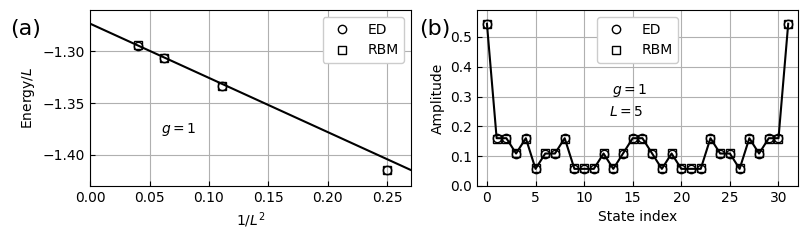

In [11]:
main()